In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import osmnx as ox
import networkx as nx

In [ ]:
import sys
from pathlib import Path

# allow imports from src/
PROJECT_ROOT = Path("...").resolve()
sys.path.append(str(PROJECT_ROOT))

# import dataloader function
from src.data.dataload import load_csv_folder_to_dataframe

DATA_DIR = PROJECT_ROOT / "data/raw"
PLOTS_DIR = PROJECT_ROOT / "outputs/plots"

In [2]:
# read csv into dataframe
df_all = pd.read_csv("df_all.csv")

In [3]:
# timestamps to datetime
df_all['iso_timestamp'] = pd.to_datetime(df_all['iso_timestamp'], utc=True, format='mixed')

# change columns to numerics
print(df_all.dtypes)
numeric_cols = [
    "channels_in", "channels_out", "channels_unknown", "channels_all", 
    "site_temperature", "site_rain_accumulation", "site_snow_accumulation"]

df_all[numeric_cols] = df_all[numeric_cols].apply(pd.to_numeric, errors='coerce')

df_all["count"] = df_all[["channels_out", "channels_in", "channels_unknown"]].fillna(0).sum(axis=1)


operator_name                          object
domain_name                            object
domain_id                               int64
counter_site                           object
counter_site_id                         int64
counter_serial                         object
longitude                             float64
latitude                              float64
timezone                               object
iso_timestamp             datetime64[ns, UTC]
channels_in                           float64
channels_out                          float64
channels_unknown                      float64
channels_all                            int64
site_temperature                      float64
site_rain_accumulation                float64
site_snow_accumulation                float64
dtype: object


In [4]:
# subset of dataframe just for one town 
df_domain = df_all[df_all["domain_name"] == "Ravensburg Tws Gmbh & Co. Kg"] # change domain name here for other towns
title_domain = df_domain["domain_name"].iloc[0]
print(title_domain)
df_domain_grouped = df_domain.groupby("counter_site")

# get coordinates for every counter site
domain_coords = {
    name: (
        df_domain_grouped.get_group(name)["latitude"].iloc[0],
        df_domain_grouped.get_group(name)["longitude"].iloc[0]
    )
    for name in df_domain_grouped.groups.keys()
}
domain_coords

Ravensburg Tws Gmbh & Co. Kg


{'01 / 02 WGT Doggenriedstraße': (np.float64(47.81064893394001),
  np.float64(9.648069441318514)),
 '03 WGT Krankenhaus Ost': (np.float64(47.80081747027417),
  np.float64(9.632134790175131)),
 '04 WGT Krankenhaus West': (np.float64(47.80105), np.float64(9.632)),
 '05 RV Eissporthalle': (np.float64(47.7933), np.float64(9.61543)),
 '06 Meersburger Brücke abwärts': (np.float64(47.78255792377975),
  np.float64(9.60396822197144)),
 '07 Meersburger Brücke aufwärts': (np.float64(47.78236168083926),
  np.float64(9.602486523685211)),
 '08 RV Bahnhofstr.': (np.float64(47.78530891015364),
  np.float64(9.607066512107853))}

In [5]:
# we need a reference latitude for the conversion
lat0 = np.mean([coord[0] for coord in domain_coords.values()])

# function to convert lat/lon to x/y in meters
def latlon_to_xy(coord, lat0=lat0):
    lat, lon = coord
    R = 6371000 # radius of earth in meters
    x = R * np.radians(lon) * np.cos(np.radians(lat0))
    y = R * np.radians(lat)
    return np.array([x, y])

# distance matrix
sites1 = list(domain_coords.keys())
dist_matrix_euclid = pd.DataFrame(index=sites1, columns=sites1, dtype=float)

# compute euclidean distances and fill the distance matrix
for a in sites1:
    for b in sites1:
        p1 = latlon_to_xy(domain_coords[a])
        p2 = latlon_to_xy(domain_coords[b])
        dist_matrix_euclid.loc[a, b] = np.linalg.norm(p1 - p2)

dist_matrix_euclid

,01 / 02 WGT Doggenriedstraße,03 WGT Krankenhaus Ost,04 WGT Krankenhaus West,05 RV Eissporthalle,06 Meersburger Brücke abwärts,07 Meersburger Brücke aufwärts,08 RV Bahnhofstr.
01 / 02 WGT Doggenriedstraße,0.000000,1616.168198,1606.302618,3109.064879,4539.804957,4635.531677,4161.855636
03 WGT Krankenhaus Ost,1616.168198,0.000000,27.747488,1501.965440,2923.953818,3019.373794,2545.688330
04 WGT Krankenhaus West,1606.302618,27.747488,0.000000,1508.233155,2934.774139,3029.671748,2555.927358
05 RV Eissporthalle,3109.064879,1501.965440,1508.233155,0.000000,1469.637146,1553.778251,1086.222769
06 Meersburger Brücke abwärts,4539.804957,2923.953818,2934.774139,1469.637146,0.000000,112.814772,383.587126
07 Meersburger Brücke aufwärts,4635.531677,3019.373794,3029.671748,1553.778251,112.814772,0.000000,473.762577
08 RV Bahnhofstr.,4161.855636,2545.688330,2555.927358,1086.222769,383.587126,473.762577,0.000000


In [6]:
# compute median of lats and lons for center point
lats = [coord[0] for coord in domain_coords.values()]
cp_lat = np.median(lats)

lons = [coord[1] for coord in domain_coords.values()]
cp_lon = np.median(lons)

# set median as center point 
center_point = (cp_lat, cp_lon)  

# access streetmaps graph with bike lanes, with median cp and 6km radius (adjust if needed)
G = ox.graph_from_point(center_point, dist=6000, network_type='bike')

In [7]:
# nodes in our graph are our counter sites 
snapped_nodes = {}
for name, (lat, lon) in domain_coords.items():
    node = ox.distance.nearest_nodes(G, X=lon, Y=lat)
    snapped_nodes[name] = node

In [8]:
# now name the nodes and compute shortest distance by bike
distances1 = {}
for i in snapped_nodes:
    for j in snapped_nodes:
        if (j, i) in distances1:
            distances1[(i, j)] = distances1[(j, i)]
            continue
        if i == j:
            distances1[(i, j)] = 0
            continue
        d = nx.shortest_path_length(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        distances1[(i, j)] = d
        print(f"distance between {i} and {j}: {d:.1f} m")


distance between 01 / 02 WGT Doggenriedstraße and 03 WGT Krankenhaus Ost: 1905.9 m
distance between 01 / 02 WGT Doggenriedstraße and 04 WGT Krankenhaus West: 1879.6 m
distance between 01 / 02 WGT Doggenriedstraße and 05 RV Eissporthalle: 3630.4 m
distance between 01 / 02 WGT Doggenriedstraße and 06 Meersburger Brücke abwärts: 5468.1 m
distance between 01 / 02 WGT Doggenriedstraße and 07 Meersburger Brücke aufwärts: 5280.6 m
distance between 01 / 02 WGT Doggenriedstraße and 08 RV Bahnhofstr.: 4651.8 m
distance between 03 WGT Krankenhaus Ost and 04 WGT Krankenhaus West: 30.7 m
distance between 03 WGT Krankenhaus Ost and 05 RV Eissporthalle: 1739.5 m
distance between 03 WGT Krankenhaus Ost and 06 Meersburger Brücke abwärts: 3576.4 m
distance between 03 WGT Krankenhaus Ost and 07 Meersburger Brücke aufwärts: 3388.9 m
distance between 03 WGT Krankenhaus Ost and 08 RV Bahnhofstr.: 2760.1 m
distance between 04 WGT Krankenhaus West and 05 RV Eissporthalle: 1750.8 m
distance between 04 WGT Kran

In [9]:
# compute all the routes as well and store them in a dict
# you can plot it too! (uncomment last line, do not recommend it for towns with many sites though)
routes = {}

keys = list(snapped_nodes.keys())

for i in keys:
    for j in keys:
        if (j, i) in routes:
            routes[(i, j)] = routes[(j, i)]
            continue
        if i == j:
            routes[(i, j)] = [snapped_nodes[i]]
            continue
        r = nx.shortest_path(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        routes[(i, j)] = r
        #ox.plot_graph_route(G, r)



- Heidelberg: 15 counter
- Stuttgart: 15 counter
- Ludwigsburg: 15 counter
- Stadt Mannheim: 14 counter
- Stadt Freiburg: 10 counter
- Stadt Reutlingen: 7 counter
- Ravensburg Tws Gmbh & Co. Kg: 7 counter
- Stadt Konstanz: 6 counter
- Tübingen: 5 counter
- Heilbronn: 4 counter
- Lörrach: 2 counter


In [10]:
# pivot table for correlation matrix
df_domain_pivot = df_domain.pivot_table(
    index = 'iso_timestamp',
    columns = 'counter_site',
    values = 'count',
    aggfunc='sum'
)

# we want to see how many timestamps have data for both sites
mask = df_domain_pivot.notna().astype(int)
overlap = mask.T.dot(mask)
overlap

counter_site,01 / 02 WGT Doggenriedstraße,03 WGT Krankenhaus Ost,04 WGT Krankenhaus West,05 RV Eissporthalle,06 Meersburger Brücke abwärts,07 Meersburger Brücke aufwärts,08 RV Bahnhofstr.
counter_site,,,,,,,
01 / 02 WGT Doggenriedstraße,30792,30410,30430,30157,30081,30792,29823
03 WGT Krankenhaus Ost,30410,45863,44555,44700,45396,45863,44775
04 WGT Krankenhaus West,30430,44555,46146,43726,45341,46145,45054
05 RV Eissporthalle,30157,44700,43726,47037,46237,47037,46703
06 Meersburger Brücke abwärts,30081,45396,45341,46237,48749,48749,47845
07 Meersburger Brücke aufwärts,30792,45863,46145,47037,48749,51882,48502
08 RV Bahnhofstr.,29823,44775,45054,46703,47845,48502,48502


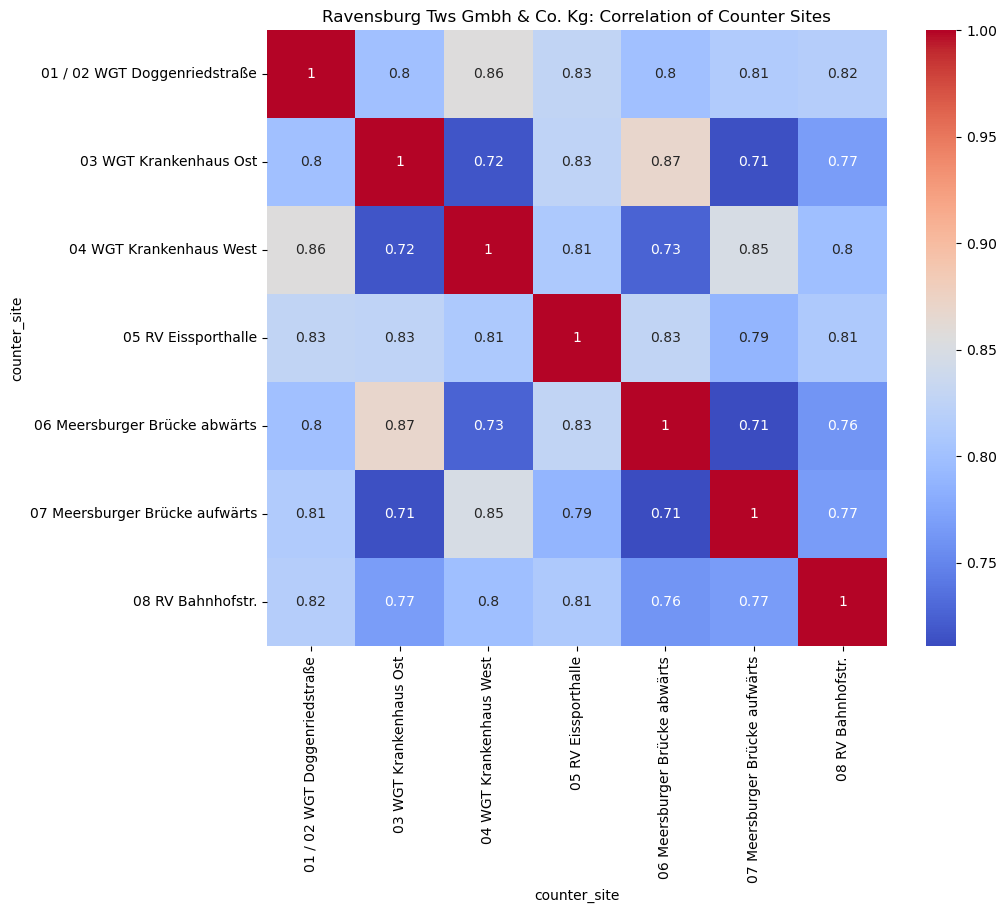

In [11]:
# compute correlation matrix and plot heatmap
# this shows correlation of counter sites based on their counts
corr_matrix = df_domain_pivot.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Correlation of Counter Sites")
plt.show()

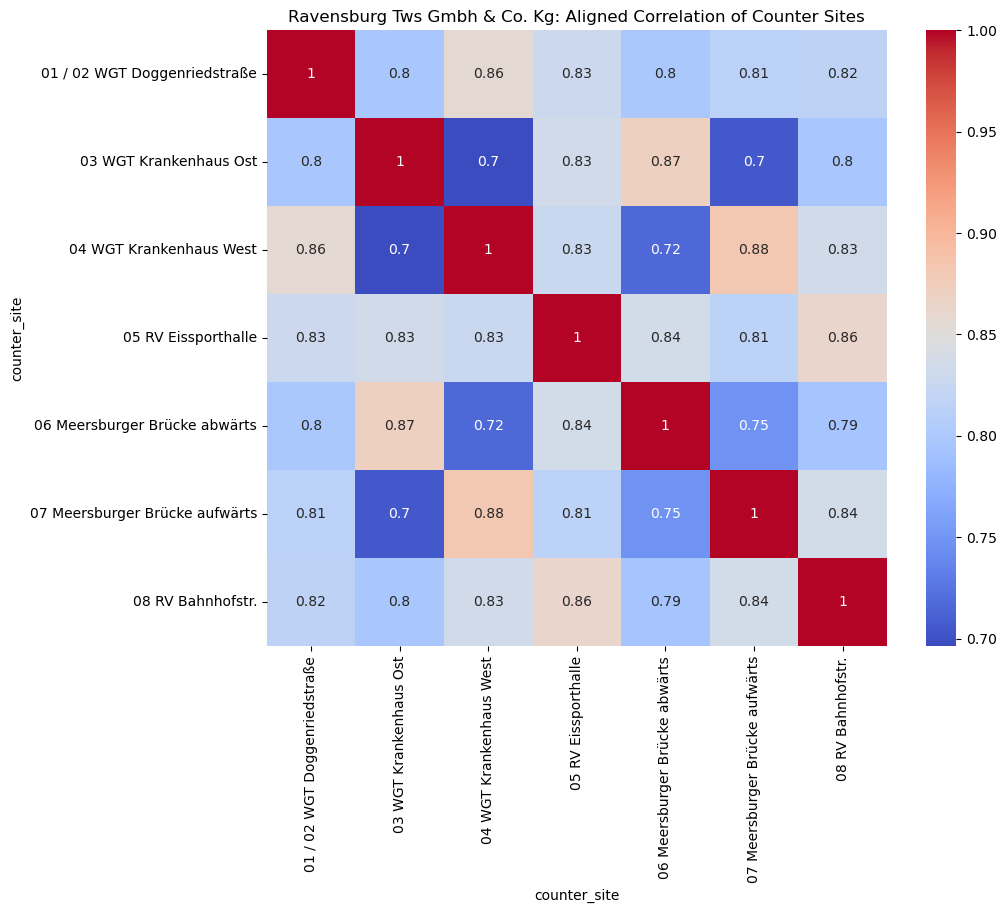

In [12]:
# correlation matrix for just times where all sites have data
# maybe more meaningful, still not sure
aligned = df_domain_pivot.dropna()
corr_matrix1 = aligned.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Aligned Correlation of Counter Sites")
plt.show()

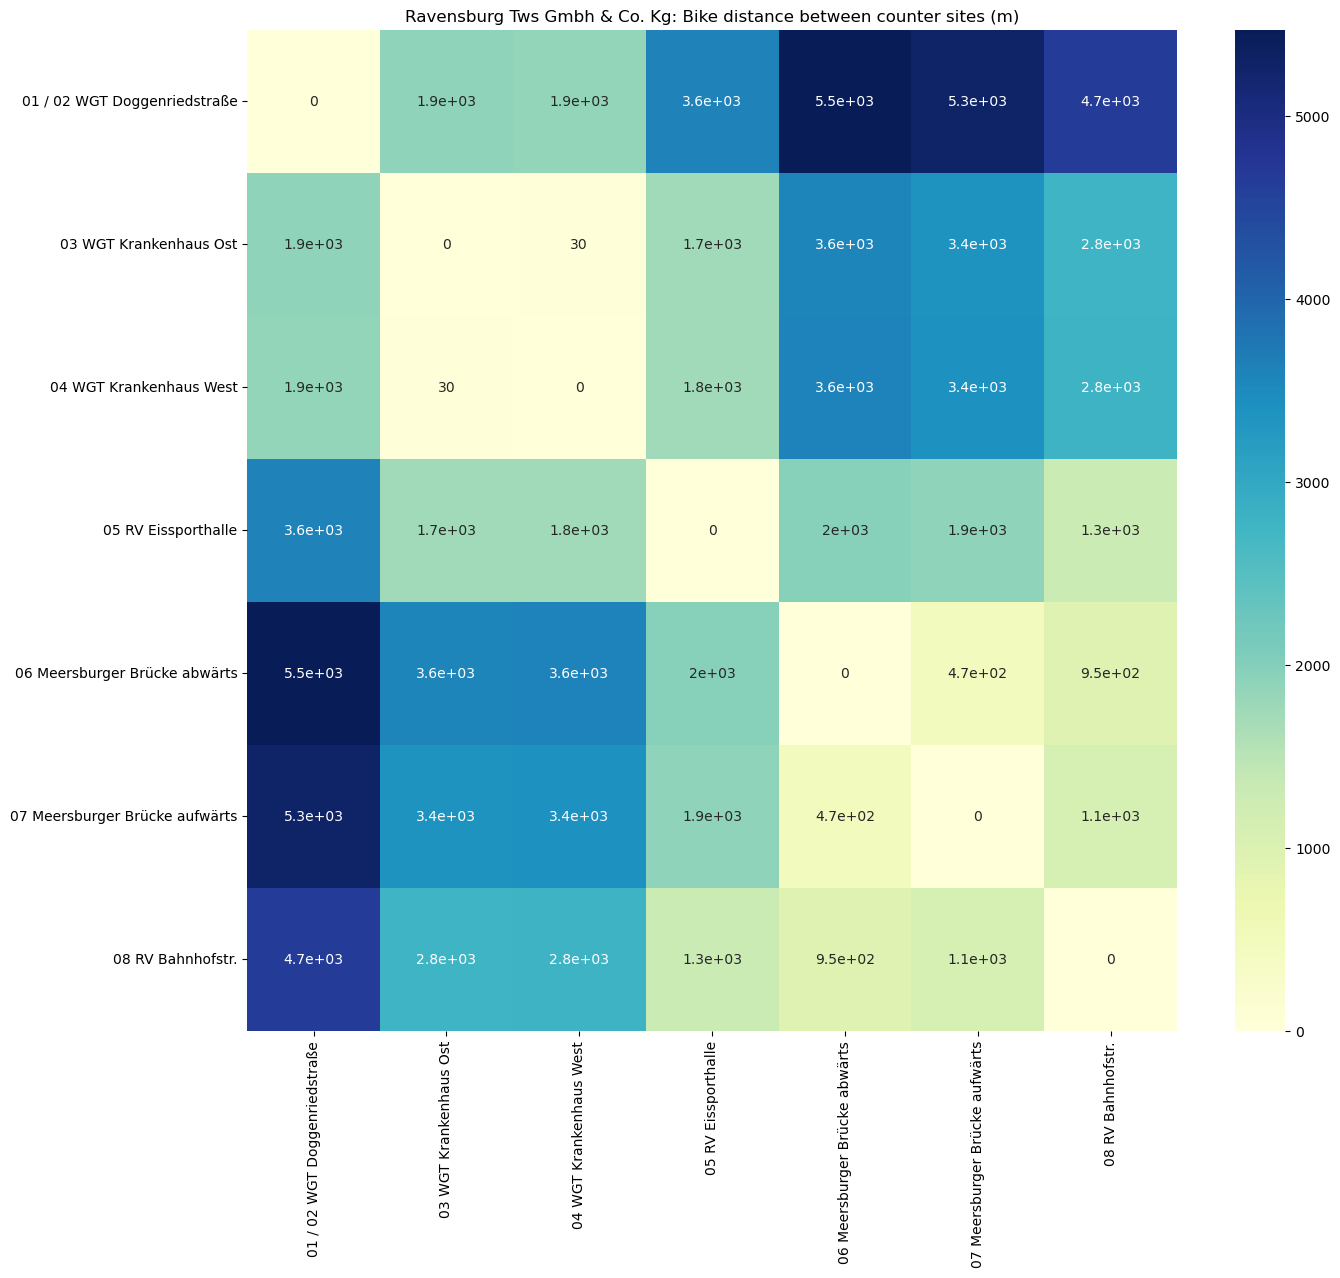

In [13]:
# now we want matrices for distances
# create distance matrix (for bike dist)
dist_matrix = pd.DataFrame(index=sites1, columns=sites1)
for (site1, site2), dist in distances1.items():
    dist_matrix.loc[site1, site2] = dist
    dist_matrix.loc[site2, site1] = dist

# fill diagonal with 0
dist_matrix.fillna(0, inplace=True)

# check shape
dist_matrix.shape

# heatmap for distances 
plt.figure(figsize=(15,13))
sns.heatmap(dist_matrix.astype(int), annot=True, cmap='YlGnBu')
plt.title(f"{title_domain}: Bike distance between counter sites (m)")
plt.show()  

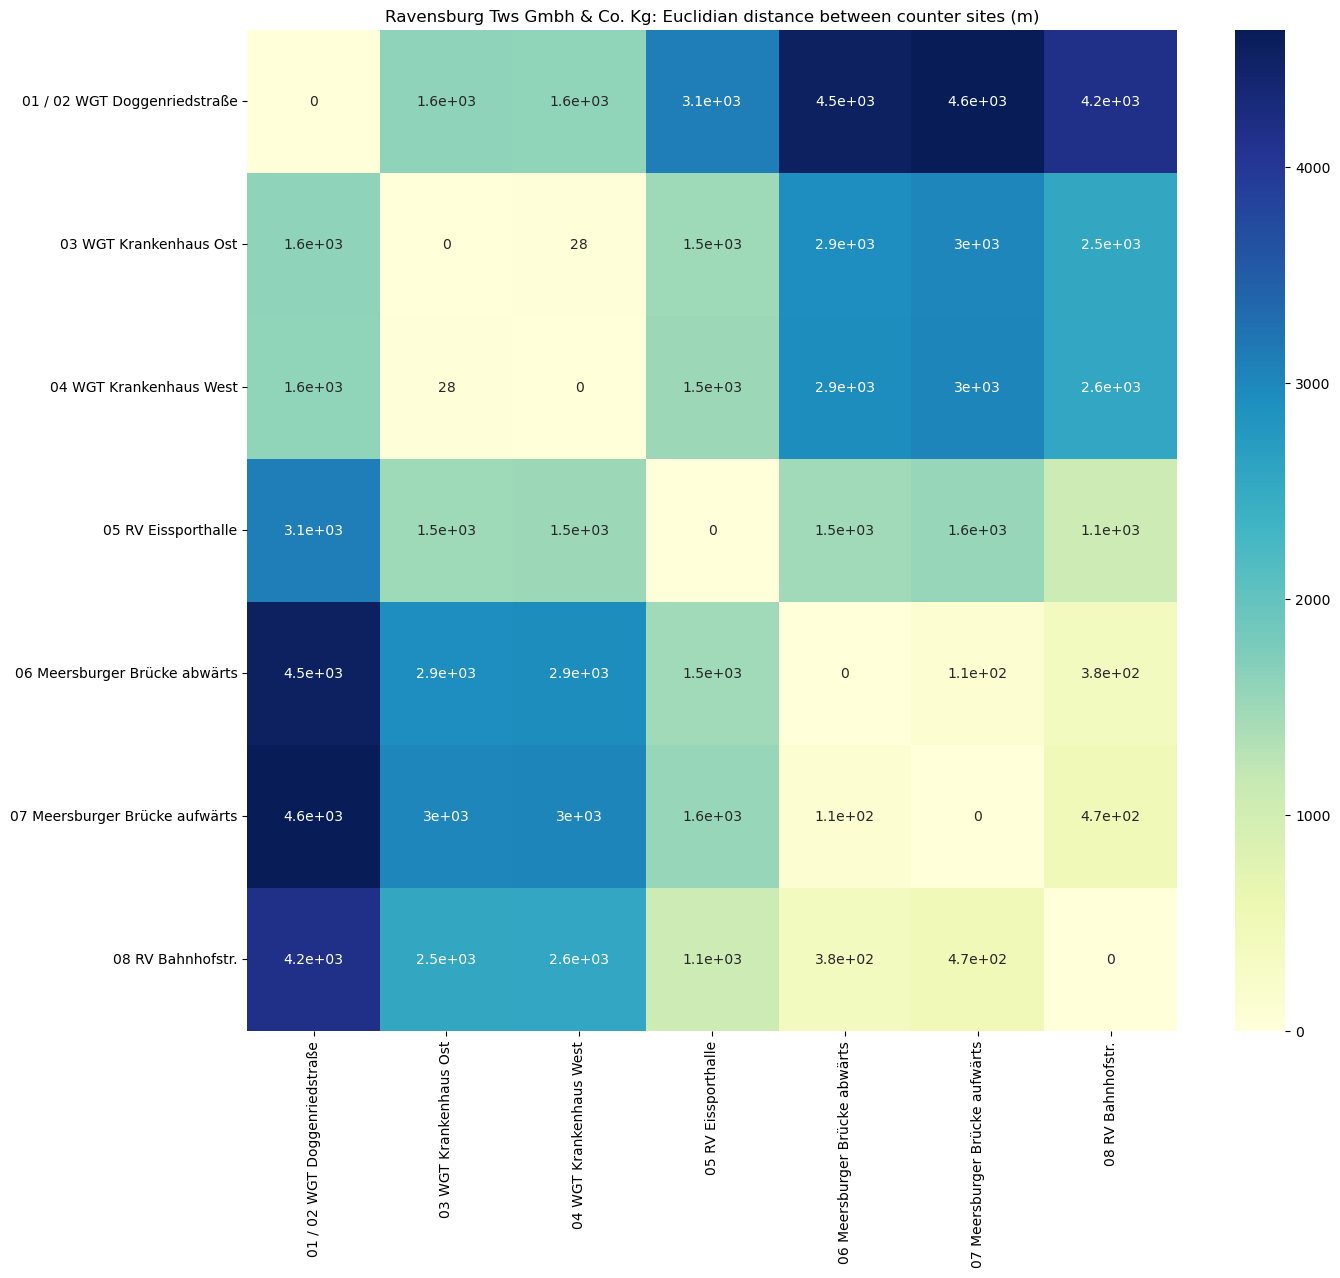

In [14]:
# now again for euclidian distances (we computed matrix already above)
plt.figure(figsize=(15,13))
sns.heatmap(dist_matrix_euclid.astype(float), annot=True, cmap='YlGnBu')
plt.title(f"{title_domain}: Euclidian distance between counter sites (m)")
plt.show()

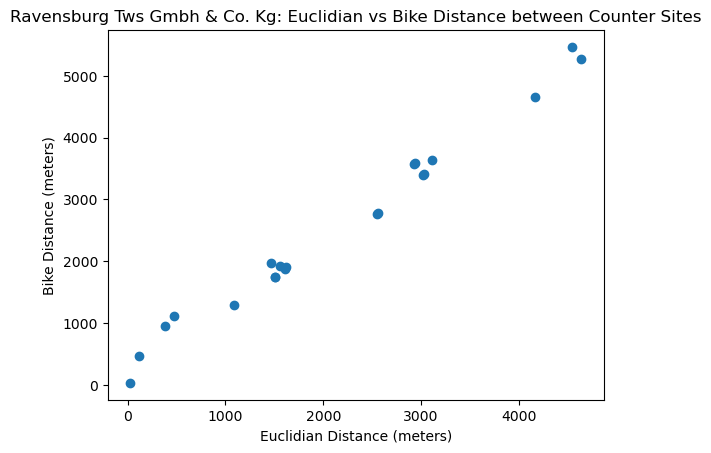

In [15]:
# euclidian vs bike distance scatter plot
euclidian_distances = []
bike_distances = []
for site_a in sites1:
    for site_b in sites1:
        if site_a >= site_b:
            continue
        euclidian_distances.append(dist_matrix_euclid.loc[site_a, site_b])
        bike_distances.append(dist_matrix.loc[site_a, site_b])
plt.scatter(euclidian_distances, bike_distances)
plt.xlabel("Euclidian Distance (meters)")
plt.ylabel("Bike Distance (meters)")
plt.title(f"{title_domain}: Euclidian vs Bike Distance between Counter Sites")
plt.show()

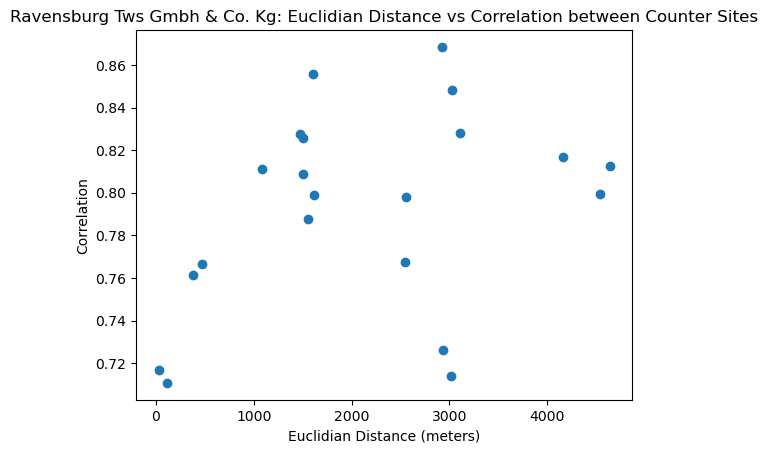

In [16]:
# euclidian distance vs correlation plot
# using euclidian distance and unaligned correlation
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix_euclid.loc[site1, site2]
        correlation = corr_matrix.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)

plt.scatter(distance_values, correlations)
plt.xlabel("Euclidian Distance (meters)")
plt.ylabel("Correlation")
plt.title(f"{title_domain}: Euclidian Distance vs Correlation between Counter Sites")
plt.show()

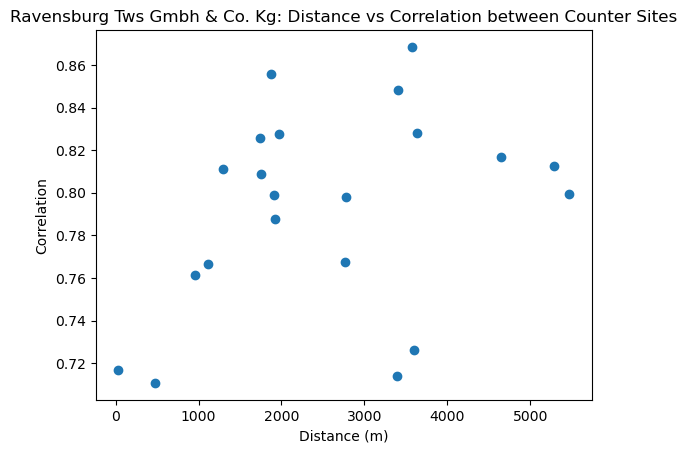

In [17]:
# distance vs correlation plot
# using bike distance and unaligned correlation
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix.loc[site1, site2]
        correlation = corr_matrix.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)


plt.scatter(distance_values, correlations)
plt.xlabel("Distance (m)")
plt.ylabel("Correlation")
plt.title(f"{title_domain}: Distance vs Correlation between Counter Sites")
plt.show()

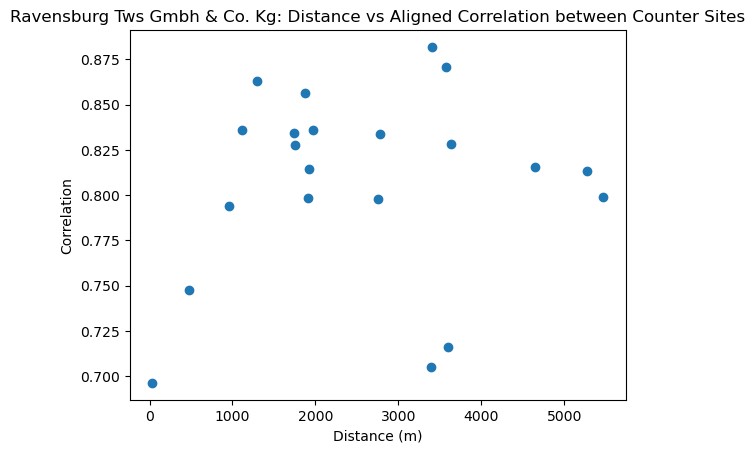

In [18]:
# distance vs correlation plot
# using bike distance and aligned correlation
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix.loc[site1, site2]
        correlation = corr_matrix1.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)


plt.scatter(distance_values, correlations)
plt.xlabel("Distance (m)")
plt.ylabel("Correlation")
plt.title(f"{title_domain}: Distance vs Aligned Correlation between Counter Sites")
plt.show()

In [19]:
################################################
# REGRESSION MODELING - SETUP                  #
################################################

import importlib
import regression_utils
importlib.reload(regression_utils)

from regression_utils import train_model

# Load city data with features
df_city = pd.read_csv('df_features.csv')
df_city = df_city[df_city['domain_name'] == title_domain].copy()

print(f"✓ Loaded {len(df_city):,} hourly records for {title_domain}")
print(f"✓ {df_city['counter_site'].nunique()} stations")
print(f"✓ regression_utils.py reloaded")

✓ Loaded 318,971 hourly records for Ravensburg Tws Gmbh & Co. Kg
✓ 7 stations
✓ regression_utils.py reloaded


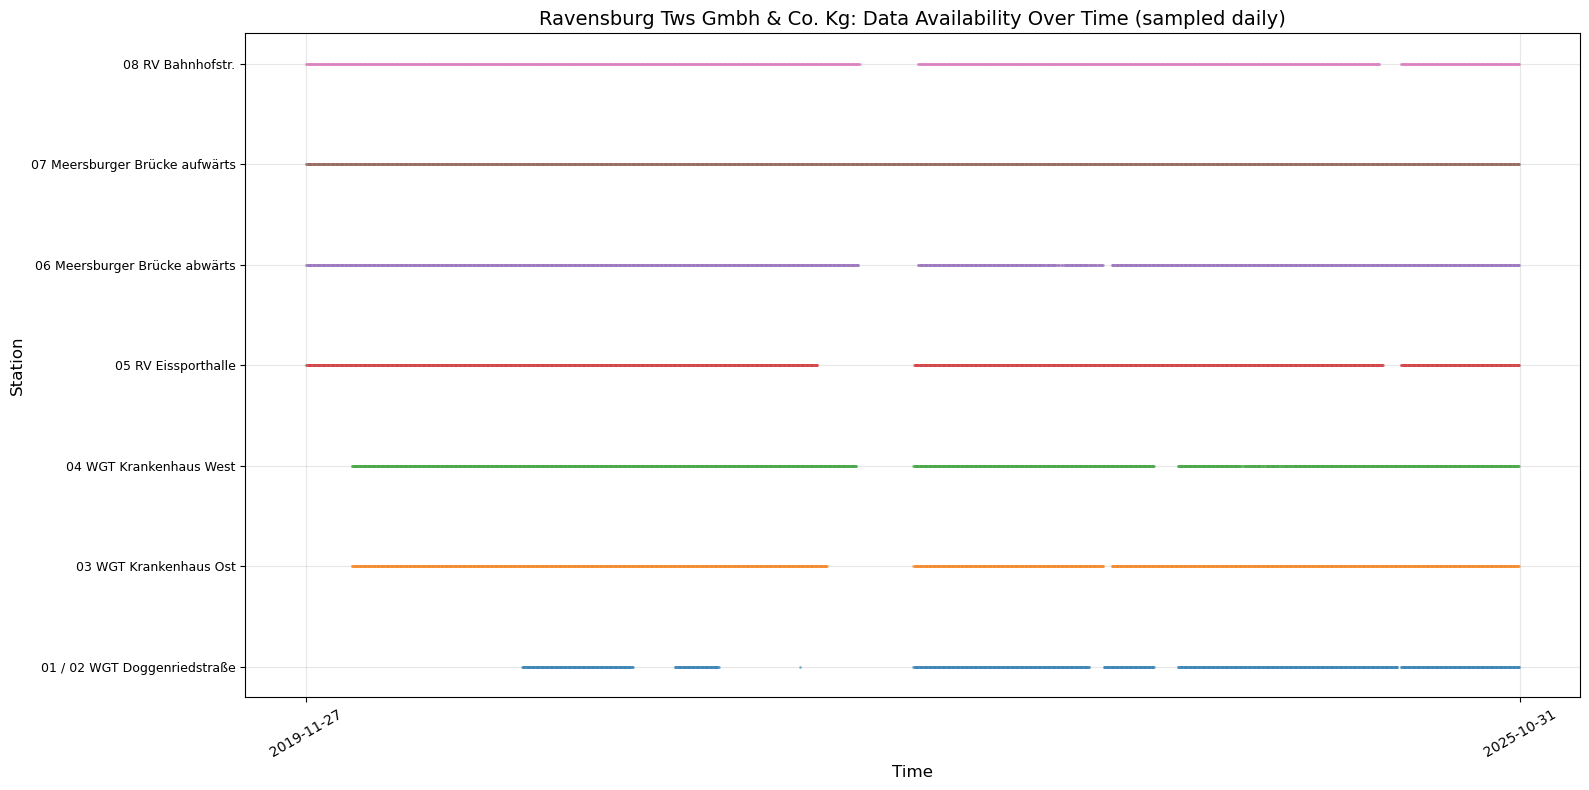


Data Availability Summary:
Total time range: 2019-11-27 23:00:00+00:00 to 2025-10-31 21:00:00+00:00
Total timestamps: 51,883

Timestamps with ALL stations: 28,962 (55.8%)

Per-station coverage:
  01 / 02 WGT Doggenriedstraße              59.3%
  03 WGT Krankenhaus Ost                    88.4%
  04 WGT Krankenhaus West                   88.9%
  05 RV Eissporthalle                       90.7%
  06 Meersburger Brücke abwärts             94.0%
  07 Meersburger Brücke aufwärts           100.0%
  08 RV Bahnhofstr.                         93.5%

Sanity check:
Start window: 2019-11-27 23:00:00+00:00 → 2019-12-04 23:00:00+00:00
  Active stations in first 7 days:   4
  Inactive stations in first 7 days: 3

End window:   2025-10-24 21:00:00+00:00 → 2025-10-31 21:00:00+00:00
  Active stations in last 7 days:    7
  Inactive stations in last 7 days:  0


In [ ]:
################################################
# DATA AVAILABILITY VISUALIZATION              #
################################################

# Create pivot table to see when each station has data
df_pivot_avail = df_city.pivot_table(
    index='iso_timestamp',
    columns='counter_site',
    values='channels_all',
    aggfunc='count'
)

# Convert index to datetime to avoid categorical axis issues
df_pivot_avail.index = pd.to_datetime(df_pivot_avail.index)

# Convert to binary (1 = has data, 0 = missing)
df_avail_binary = df_pivot_avail.notna().astype(int)

# Sample data for visualization (every 24 hours to avoid overplotting)
df_sample = df_avail_binary.iloc[::24]

# Plot
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_facecolor("white")
fig.patch.set_facecolor("white")

for i, station in enumerate(df_sample.columns):
    # Create line at y=i when data exists
    times = df_sample.index[df_sample[station] == 1]
    if len(times) > 0:
        ax.scatter(times, [i] * len(times), s=1, alpha=0.5)

# y-axis labels
ax.set_yticks(range(len(df_sample.columns)))
ax.set_yticklabels([s[:30] for s in df_sample.columns], fontsize=9)

# x-axis: ensure full time range is shown
start = df_avail_binary.index.min()
end = df_avail_binary.index.max()
#ax.set_xlim(start, end)

# Show start and end timestamps as tick labels
ax.set_xticks([start, end])
ax.set_xticklabels(
    [start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d")],
    rotation=30
)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Station', fontsize=12)
ax.set_title(f'{title_domain}: Data Availability Over Time (sampled daily)', fontsize=14)
ax.grid(True, alpha=0.3)
plt.tight_layout()
# safe figure named after city 
# # in directory /plots
plt.savefig(os.join.path(PLOTS_DIR, 'distcorr/data_availability_{title_domain}.png'), dpi=300)
plt.show()

# Show statistics
print(f"\nData Availability Summary:")
print(f"Total time range: {df_avail_binary.index.min()} to {df_avail_binary.index.max()}")
print(f"Total timestamps: {len(df_avail_binary):,}")
print(f"\nTimestamps with ALL stations: {df_avail_binary.all(axis=1).sum():,} "
      f"({df_avail_binary.all(axis=1).sum()/len(df_avail_binary)*100:.1f}%)")
print(f"\nPer-station coverage:")
for station in df_avail_binary.columns:
    coverage = df_avail_binary[station].sum() / len(df_avail_binary) * 100
    print(f"  {station[:40]:40} {coverage:5.1f}%")

# --- Sanity check: first & last 7 days ---

# Full range
first_ts = df_avail_binary.index.min()
last_ts  = df_avail_binary.index.max()

# Window definitions
start_window_end = first_ts + pd.Timedelta(days=7)
end_window_start = last_ts  - pd.Timedelta(days=7)

start_window = df_avail_binary[(df_avail_binary.index >= first_ts) &
                               (df_avail_binary.index <= start_window_end)]

end_window = df_avail_binary[df_avail_binary.index >= end_window_start]

# Active if at least one "1" appears in that window
active_start = list(start_window.columns[start_window.sum(axis=0) > 0])
inactive_start = list(start_window.columns[start_window.sum(axis=0) == 0])

active_end = list(end_window.columns[end_window.sum(axis=0) > 0])
inactive_end = list(end_window.columns[end_window.sum(axis=0) == 0])

print("\nSanity check:")
print(f"Start window: {first_ts} → {start_window_end}")
print(f"  Active stations in first 7 days:   {len(active_start)}")
print(f"  Inactive stations in first 7 days: {len(inactive_start)}")

print(f"\nEnd window:   {end_window_start} → {last_ts}")
print(f"  Active stations in last 7 days:    {len(active_end)}")
print(f"  Inactive stations in last 7 days:  {len(inactive_end)}")

In [21]:
################################################
# TRAIN MODELS FOR ALL STATIONS               #
################################################

all_results = []

for station_idx, station in enumerate(sites1, 1):
    print(f"\n[{station_idx}/{len(sites1)}] {station}")
    
    # Get station data
    df_station = df_city[df_city['counter_site'] == station].copy()
    df_station = df_station.dropna(subset=['channels_all'])
    df_station = df_station.sort_values('iso_timestamp')
    
    # Skip if insufficient data
    if len(df_station) < 1000:
        print(f"    ⊗ Skipped - only {len(df_station)} records")
        continue
    
    # Train model (prints data info internally)
    results, model, features = train_model(df_station, station, df_city)
    
    # Format feature names
    temporal_str = ', '.join(results['temporal_features'])
    weather_str = ', '.join(results['weather_features']) if results['weather_features'] else 'none'
    
    all_results.append(results)
    
    print(f"    Features: {temporal_str} + {weather_str} + {results['n_stations']} station counts = {results['n_features']} total")
    print(f"    Test R² = {results['test_r2']:.4f} | RMSE = {results['test_rmse']:.2f}")

# Create summary DataFrame
results_df = pd.DataFrame(all_results)

print(f"\n{'='*70}")
print(f"SUMMARY - {title_domain}")
print(f"{'='*70}")
print(f"\nAverage Test R²:   {results_df['test_r2'].mean():.4f} ± {results_df['test_r2'].std():.4f}")
print(f"Average Test RMSE: {results_df['test_rmse'].mean():.2f} ± {results_df['test_rmse'].std():.2f}")
print(f"Average Test MAE:  {results_df['test_mae'].mean():.2f} ± {results_df['test_mae'].std():.2f}")

# Print results as markdown table
print(f"\n## Results Table\n")
print("| Station | Test R² | RMSE | MAE | Features |")
print("|---------|---------|------|-----|----------|")
for _, row in results_df.iterrows():
    print(f"| {row['station'][:30]} | {row['test_r2']:.4f} | {row['test_rmse']:.2f} | {row['test_mae']:.2f} | {row['n_features']} |")

# Save results
results_df.to_csv(f'regression_results_{title_domain.replace(" ", "_")}.csv', index=False)
print(f"\n✓ Saved: regression_results_{title_domain.replace(' ', '_')}.csv")


[1/7] 01 / 02 WGT Doggenriedstraße
    Complete coverage: 28,962/51,883 hours (55.8%)
    Time frame: 2020-12-17 10:00:00+00:00 to 2025-10-31 02:00:00+00:00 (1778 days, 28,962 hours)
    Features: hour, day_of_week, month + none + 6 station counts = 9 total
    Test R² = 0.7970 | RMSE = 4.86

[2/7] 03 WGT Krankenhaus Ost
    Complete coverage: 28,962/51,883 hours (55.8%)
    Time frame: 2020-12-17 10:00:00+00:00 to 2025-10-31 02:00:00+00:00 (1778 days, 28,962 hours)
    Features: hour, day_of_week, month + none + 6 station counts = 9 total
    Test R² = 0.8018 | RMSE = 7.44

[3/7] 04 WGT Krankenhaus West
    Complete coverage: 28,962/51,883 hours (55.8%)
    Time frame: 2020-12-17 10:00:00+00:00 to 2025-10-31 02:00:00+00:00 (1778 days, 28,962 hours)
    Features: hour, day_of_week, month + none + 6 station counts = 9 total
    Test R² = 0.8522 | RMSE = 10.61

[4/7] 05 RV Eissporthalle
    Complete coverage: 28,962/51,883 hours (55.8%)
    Time frame: 2020-12-17 10:00:00+00:00 to 2025-